In [35]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

In [43]:
res = pickle.load(open('data/meta_representation_results', 'rb'))

# Visualize flow for single step

In [88]:
%run bart_representation_analysis

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


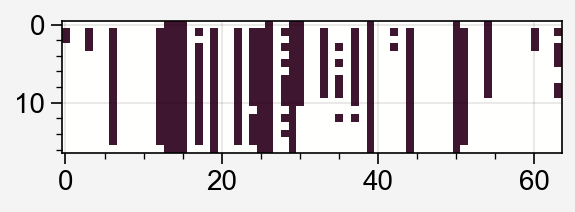

In [ ]:
idx = (0, 0, 4, 9)
chkidx, model, obs_rms, r = select_random_model(idx=idx, load_models=True)
dec_nodes = []
scores = []
for ep in range(17):
    dec_nodes.append(find_decision_nodes(r, model, ep, threshold=0.1))
    
fig, ax = pplt.subplots()
ax.imshow(np.array(dec_nodes)*1)
decision_nodes = np.mean(np.array(dec_nodes)*1, axis=0) > 0.5

In [89]:
%run bart_representation_analysis

In [92]:

idx = (0, 0, 4, 9)
ep = 10
chkidx, model, obs_rms, r = select_random_model(idx=idx, load_models=True)
dec_nodes, scores = find_decision_nodes(r, model, ep, threshold=0.1, 
                                        fixed_stim=False, ret_scores=True)
dec_nodes, scores2 = find_decision_nodes(r, model, ep, threshold=0.1, 
                                        fixed_stim=True, ret_scores=True)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


In [100]:
scores

array([-6.76131644e-03,  2.11534387e-03,  2.71668435e-04, -1.07973606e-03,
        2.99578074e-03, -8.34659854e-03,  2.76132270e-02,  7.39906936e-04,
        1.46031471e-03,  5.04518642e-04,  1.61986466e-03,  3.36049532e-03,
        2.26710924e-02,  4.53239587e-02,  4.68253400e-02,  2.40685250e-02,
        1.15773228e-03,  3.51042156e-02,  2.68251487e-05,  3.33676345e-02,
        3.55415708e-03,  1.03095068e-02,  8.25914219e-03,  1.94861774e-03,
        9.14868733e-03,  2.67835622e-02,  4.26526875e-02, -1.99744397e-03,
        5.53920929e-05,  4.36413008e-02,  1.07460372e-02, -4.92026712e-05,
       -2.81420473e-04,  6.04173651e-03,  2.39751041e-03,  2.23389957e-02,
        6.48037530e-04,  1.61338810e-02, -1.11454385e-03,  1.46472332e-02,
       -3.93240734e-04, -7.39358432e-03,  5.48733687e-03,  2.49046053e-03,
        2.87208183e-02,  6.65183973e-05,  1.17105343e-03, -4.01674823e-05,
        3.19251748e-04, -1.07628357e-03,  4.36125890e-02,  1.28875907e-02,
       -4.26506370e-05, -

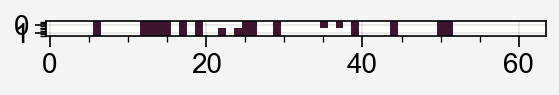

In [103]:
im = np.array([
    (scores > np.percentile(scores, 75))*1,
    (scores2 > np.percentile(scores2, 75))*1,
])

fig, ax = pplt.subplots()
ax.imshow(im)

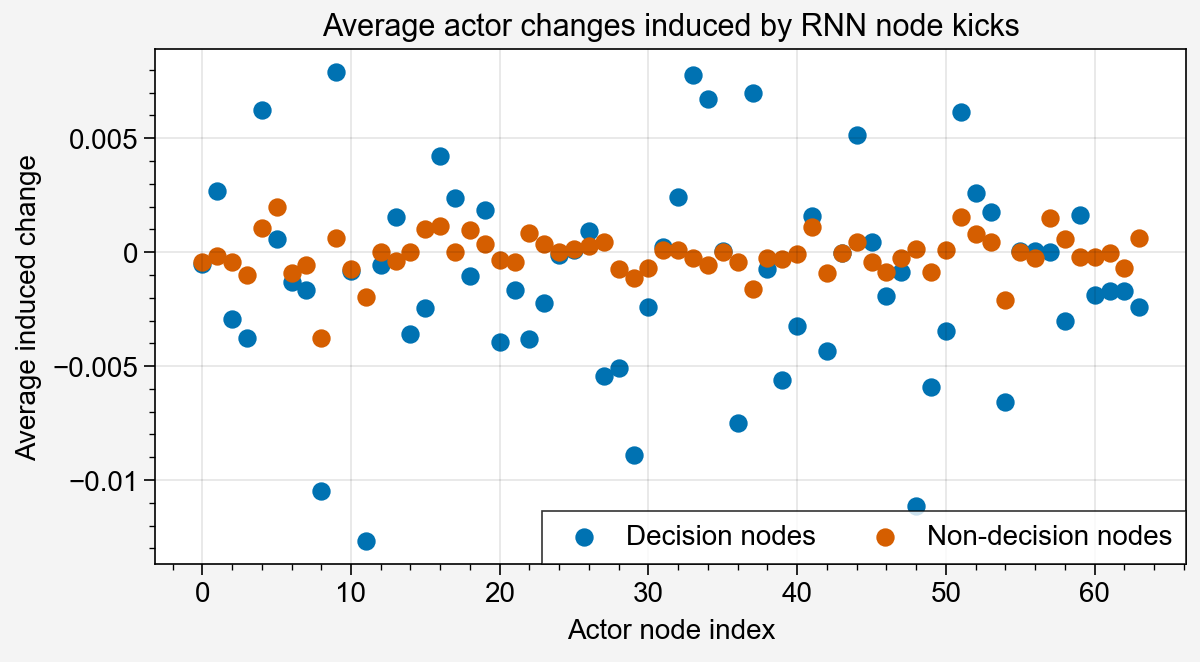

In [87]:
ep = 10
presses = np.argwhere((r['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(r['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
delt_actor0, probs = measure_rnn_influence_multi(r, model, ep, penult_steps,
                                            decision_nodes=decision_nodes,
                                            large_kick=False, ap=True)

fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

In [69]:
ep = 10
presses = np.argwhere((r['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(r['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1

nsteps = len(penult_steps)
o = r['obs'][ep][0]
rnn_hx_mod = torch.tensor(np.zeros((nsteps, 64, 64)), dtype=torch.float)
obs = torch.tensor(np.zeros((nsteps, 64, o.shape[0])), dtype=torch.float)
masks = torch.tensor(r['masks'][ep][0])
probs = np.zeros(nsteps)

for i, step in enumerate(penult_steps):
    rnn_hx = r['rnn_hxs'][ep][step]
    o = r['obs'][ep][step]
    probs[i] = r['action_probs'][ep][step][1]
    delt_rnn = r['rnn_hxs'][ep][step+1] - r['rnn_hxs'][ep][step]
    delt_rnn = torch.tensor(np.sign(delt_rnn)*2)
    
    
    for j in range(64):
        rnn_hx_mod[i, j] = torch.tensor(rnn_hx)
        obs[i, j] = torch.tensor(o)
        
    for j in range(64):
        rnn_hx_mod[i, j, j] += delt_rnn[j]

obs = obs.reshape(64*nsteps, o.shape[0])
rnn_hx_mod = rnn_hx_mod.reshape(64*nsteps, 64)
output = model.act(obs, rnn_hx_mod, masks)
p = output['probs'][:, 1].detach()
p = np.array(p).reshape(nsteps, 64)
scores = (p - probs.reshape(-1, 1)).mean(axis=0)

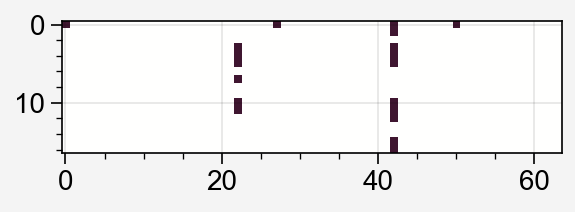

In [65]:
idx = (1, 3, 0, 1)
# chkidx, model, obs_rms, r = select_random_model(idx=idx, load_models=True)
chkidx = select_random_model(idx=idx)
fig, ax = pplt.subplots()
ax.imshow(res['all_decision_nodes'][chkidx])

In [37]:
postfix = ''
model = 1.2
t = 2
chk = 100
ep = 12

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
decision_nodes = find_decision_nodes(res, model, ep)
delt_actor0, probs = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=decision_nodes,
                                            large_kick=False, ap=True)

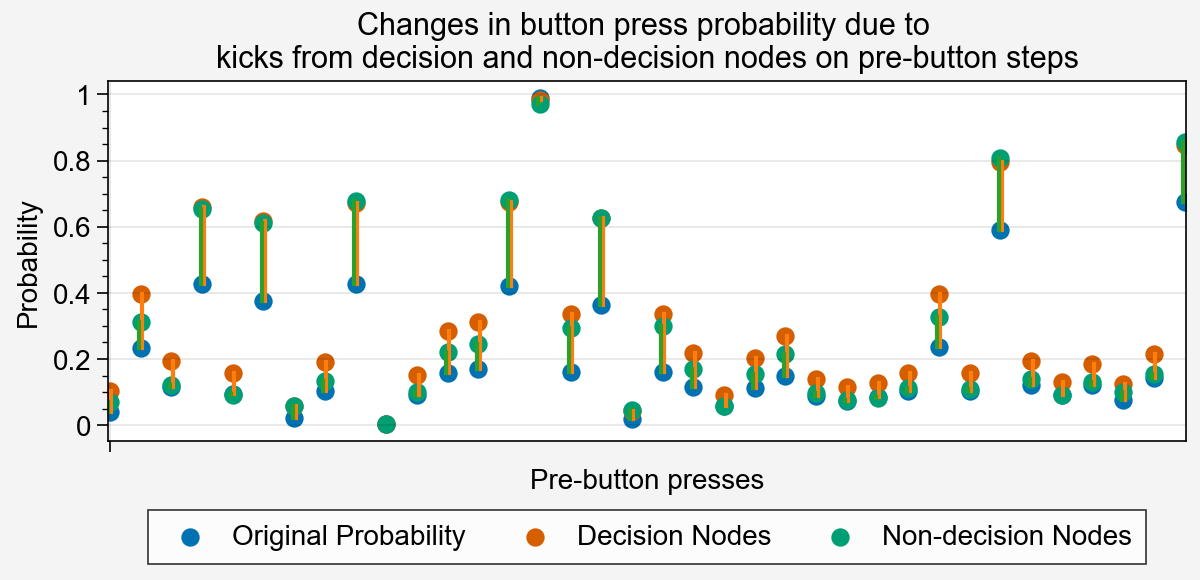

In [283]:
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
true_probs = res['action_probs'][ep][penult_steps, 1]
ax.scatter(true_probs, label='Original Probability')
ax.scatter(probs[:, 0], label='Decision Nodes')
ax.scatter(probs[:, 1], label='Non-decision Nodes')
for i in range(len(true_probs)):
    ax.plot([i+0.05, i+0.05], [true_probs[i], probs[i, 0]], c=rgb_colors[1])
    ax.plot([i-0.05, i-0.05], [true_probs[i], probs[i, 1]], c=rgb_colors[2])
    
ax.legend(loc='b')
ax.format(xlabel='Pre-button presses', xlocator=range(1), xformatter=[''],
          ylabel='Probability', 
          title='Changes in button press probability due to \nkicks from decision and non-decision nodes on pre-button steps')

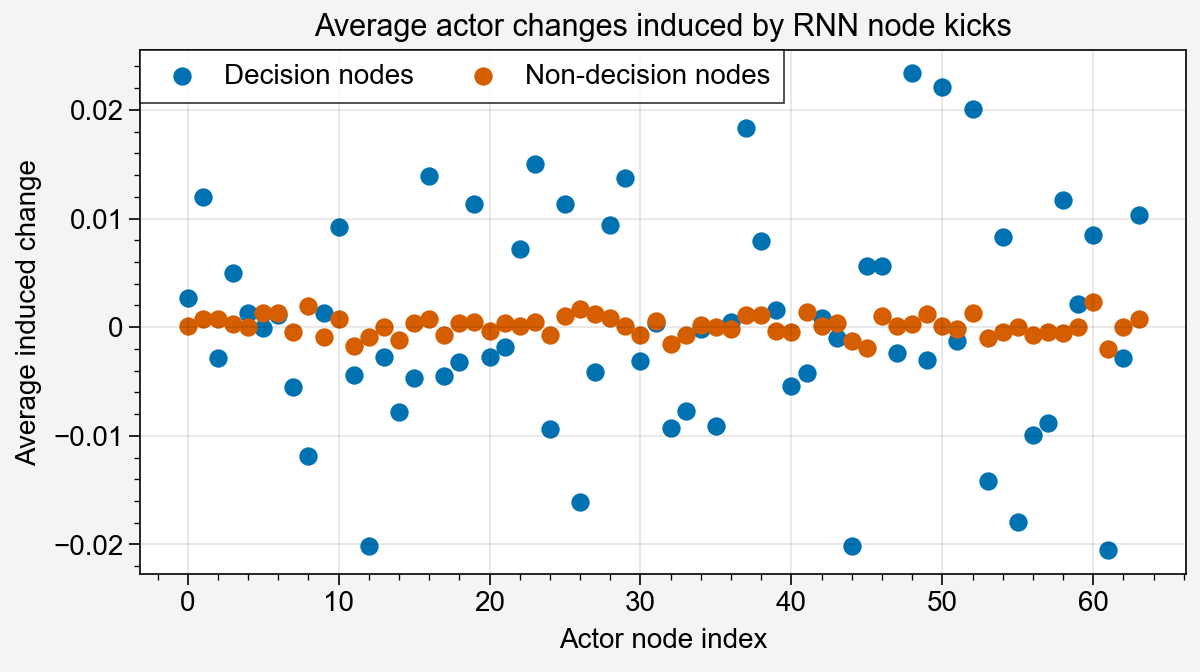

In [296]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

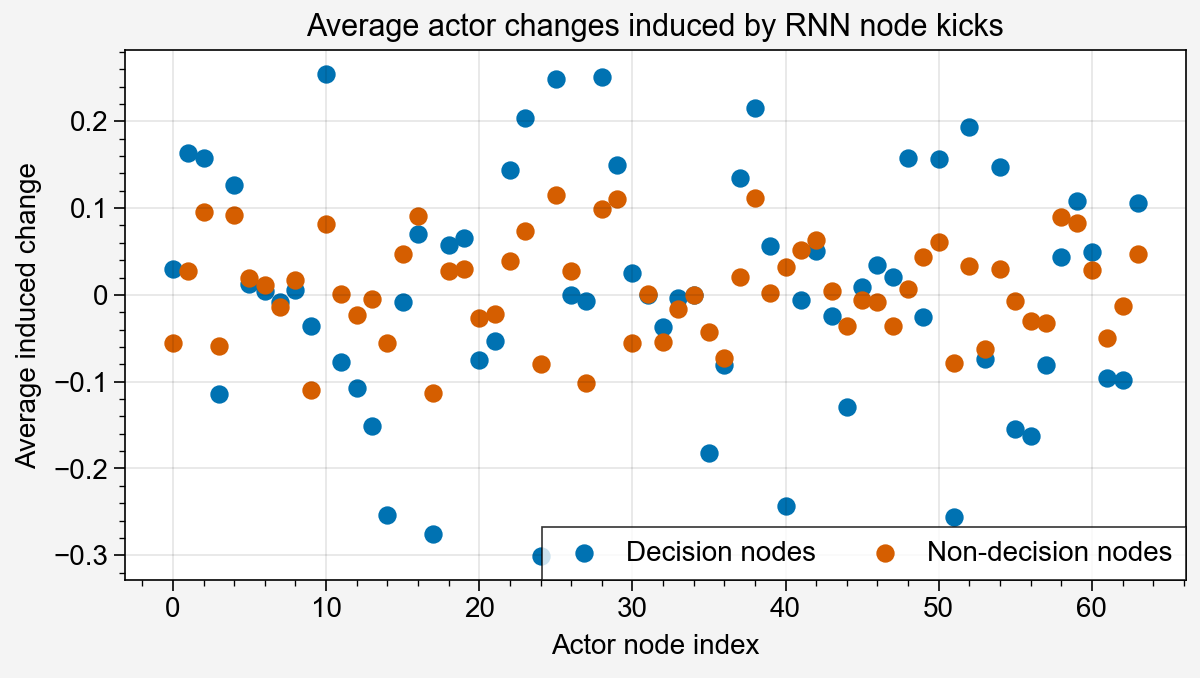

In [346]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0], label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1], label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

## Visualize individual node stimulated affects on probability

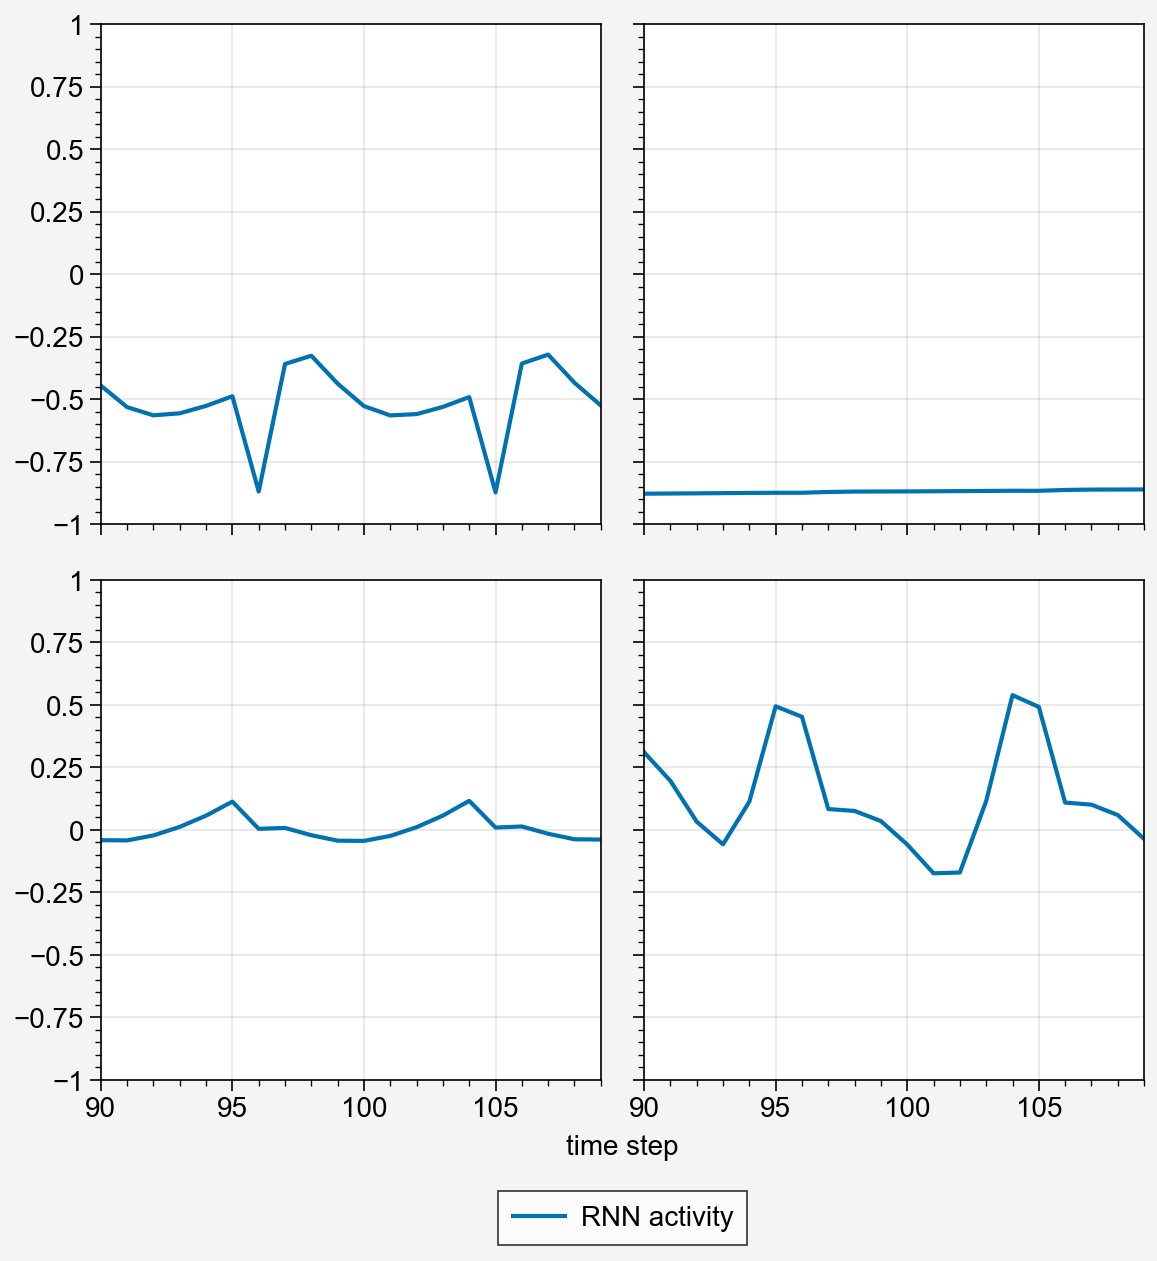

In [ ]:
ep = 8
step1 = 90
step2 = 110
bstep = res['data']['balloon_step'][ep]
pop = res['data']['popped'][ep]


steps = np.arange(step1, step2)

# Measure change from kick
nsteps = len(steps)
o = res['obs'][ep][0]
rnn_hx_mod = torch.tensor(np.zeros((nsteps, 64, 64)), dtype=torch.float)
obs = torch.tensor(np.zeros((nsteps, 64, o.shape[0])), dtype=torch.float)
masks = torch.tensor(res['masks'][ep][0])
probs = np.zeros(nsteps)
for i, step in enumerate(steps):
    rnn_hx = res['rnn_hxs'][ep][step]
    o = res['obs'][ep][step]
    probs[i] = res['action_probs'][ep][step][1]
    delt_rnn = res['rnn_hxs'][ep][step+1] - res['rnn_hxs'][ep][step]
    delt_rnn = torch.tensor(np.sign(delt_rnn)*2)
    for j in range(64):
        rnn_hx_mod[i, j] = torch.tensor(rnn_hx)
        obs[i, j] = torch.tensor(o)
    for j in range(64):
        rnn_hx_mod[i, j, j] += delt_rnn[j]
obs = obs.reshape(64*nsteps, o.shape[0])
rnn_hx_mod = rnn_hx_mod.reshape(64*nsteps, 64)
output = model.act(obs, rnn_hx_mod, masks)
p = output['probs'][:, 1].detach()
p_changed = np.array(p).reshape(nsteps, 64)
scores = (p - probs.reshape(-1, 1)).mean(axis=0)

decision_nodes = find_decision_nodes(res, model, ep)
idxs = [0, 1, 2, 3]
fig, ax = pplt.subplots(nrows=2, ncols=2)
ap = res['action_probs'][ep][:, 1]
for i, idx in enumerate(idxs):
    lines = []
    a = res['rnn_hxs'][ep][step1:step2, idx]
    x = np.arange(step1, step2)
    lines.append(ax[i].plot(x, a, label='RNN activity'))
    # lines.append(ax[i].plot(x, ap[step1:step2], label='Button press prob'))
    # lines.append(ax[i].plot(x, p_changed[:, idx], 
    #                 label='Prob after stimulation', linestyle='--'))
    # for s in bstep:
    #     if s in range(step1, step2):
    #         p = ax[i].scatter(s, ap[s], c=rgb_colors[2], label='Banked action')
    #         if len(lines) == 2:
    #             lines.append(p)

fig.legend(lines, loc='b', ncols=2)

ax.format(ylim=[-1, 1], xlabel='time step')

In [39]:
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
decision_nodes = find_decision_nodes(res, model, ep)
delt_actor0, delt_critic0 = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=decision_nodes,
                                            large_kick=False, critic_change=True)

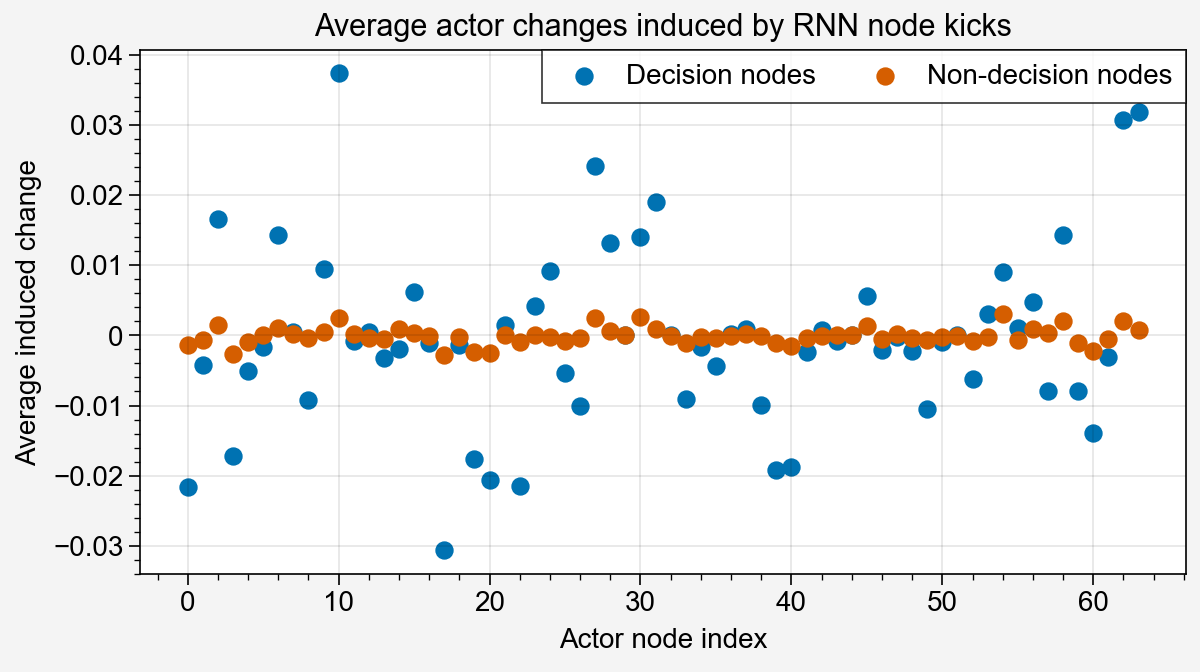

In [42]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

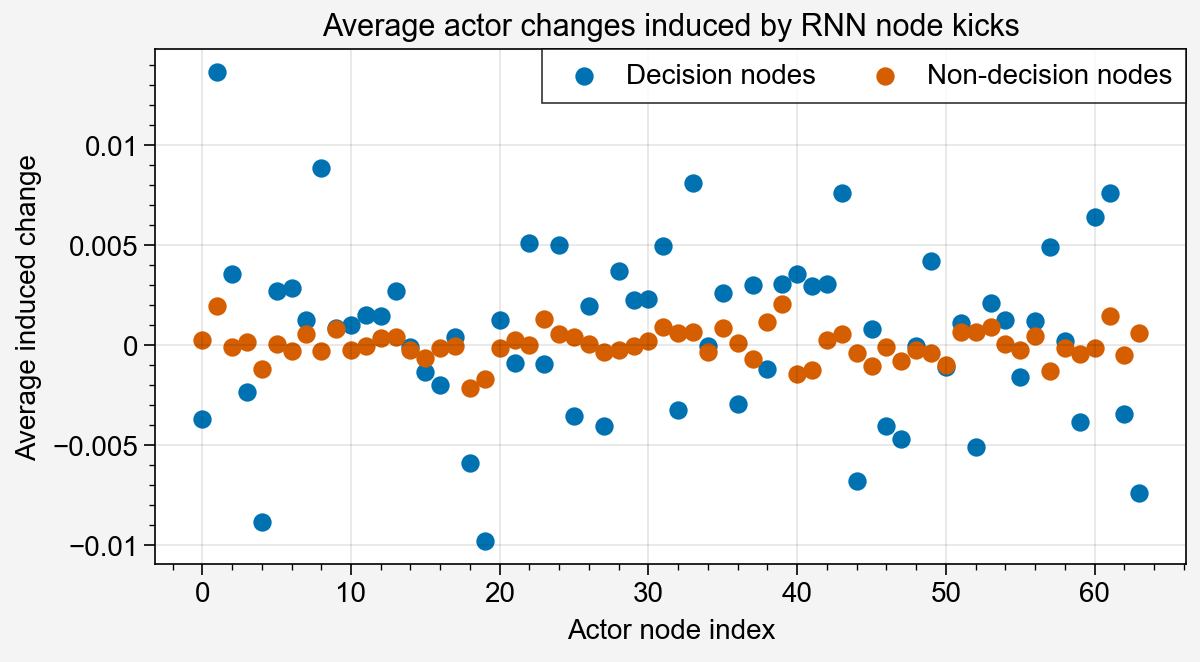

In [43]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_critic0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_critic0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

### Perform for random 6 nodes for comparison to decision nodes

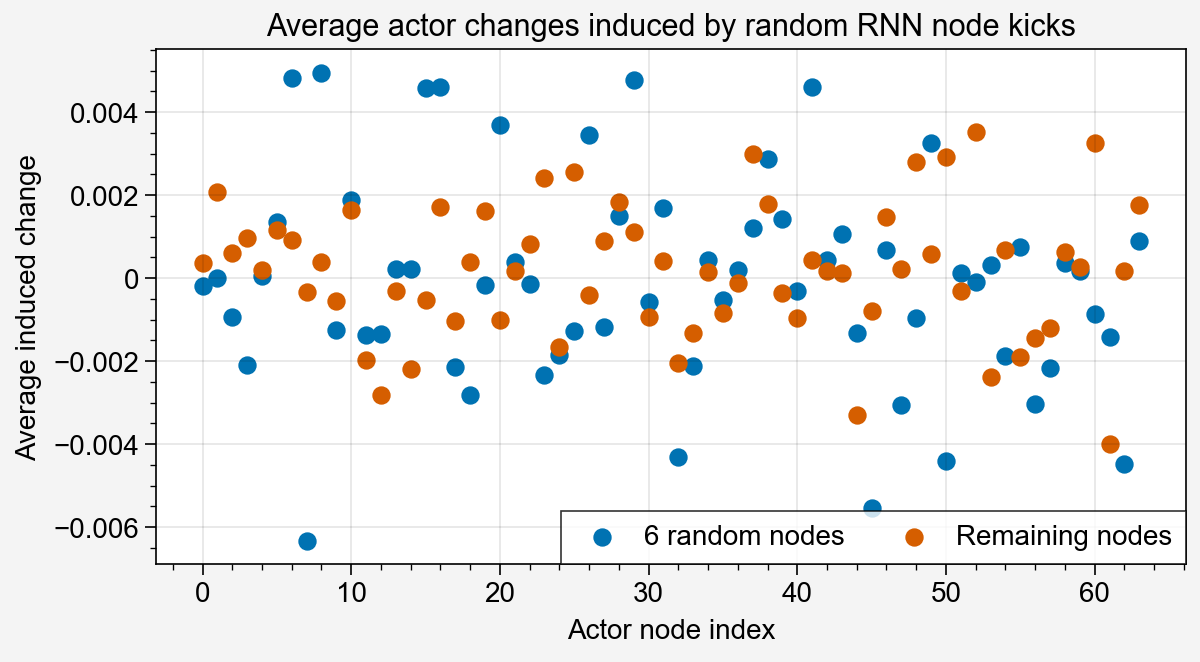

In [304]:
postfix = ''
model = 1.2
t = 2
chk = 100
ep = 12

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
# decision_nodes = find_decision_nodes(res, model, ep)
random_nodes = np.full(64, False)
random_nodes[np.random.choice(np.arange(64), (6,))] = True
delt_actor0, probs = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=random_nodes,
                                            large_kick=False, ap=True)
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='6 random nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Remaining nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by random RNN node kicks')
ax.legend()

# Average decision flows across agents

## Decision nodes across training

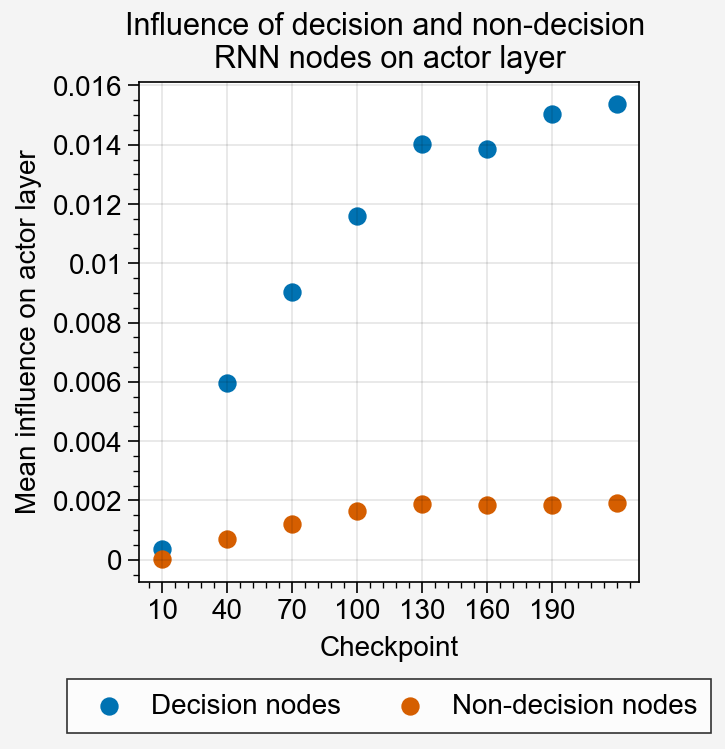

In [15]:
fig, ax = pplt.subplots()
dec_flow_scores = res['dec_flow_scores'][0]
ax.scatter(dec_flow_scores.mean(axis=(0, 1, 2))[:, 0], label='Decision nodes')
ax.scatter(dec_flow_scores.mean(axis=(0, 1, 2))[:, 1], label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(7), xformatter=[str(c) for c in chks],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer')

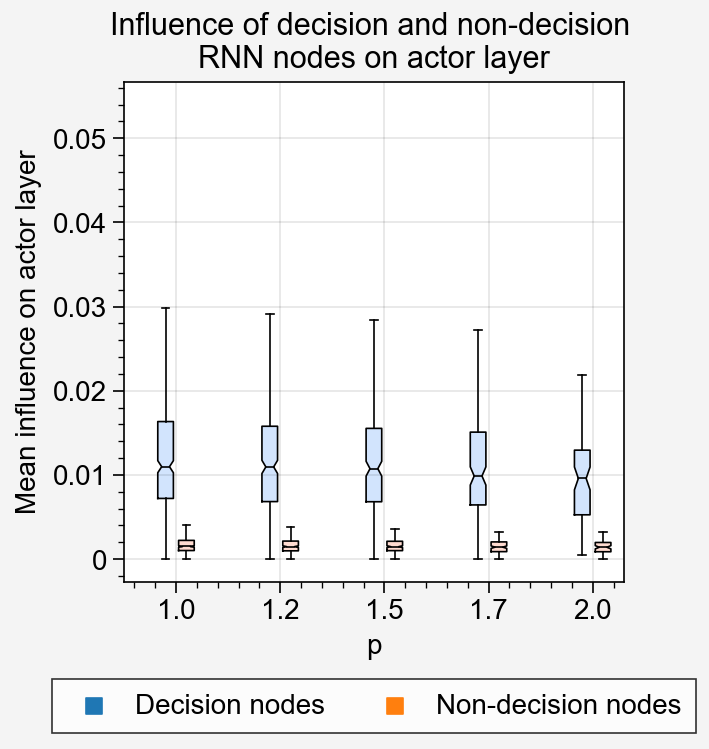

In [20]:
fig, ax = pplt.subplots()
dec_flow_scores = res['dec_flow_scores'][0]
for i in range(len(models)):
    dec = dec_flow_scores[:, i:, :, :, 0].reshape(-1)
    nondec = dec_flow_scores[:, i:, :, :, 1].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 4.4])

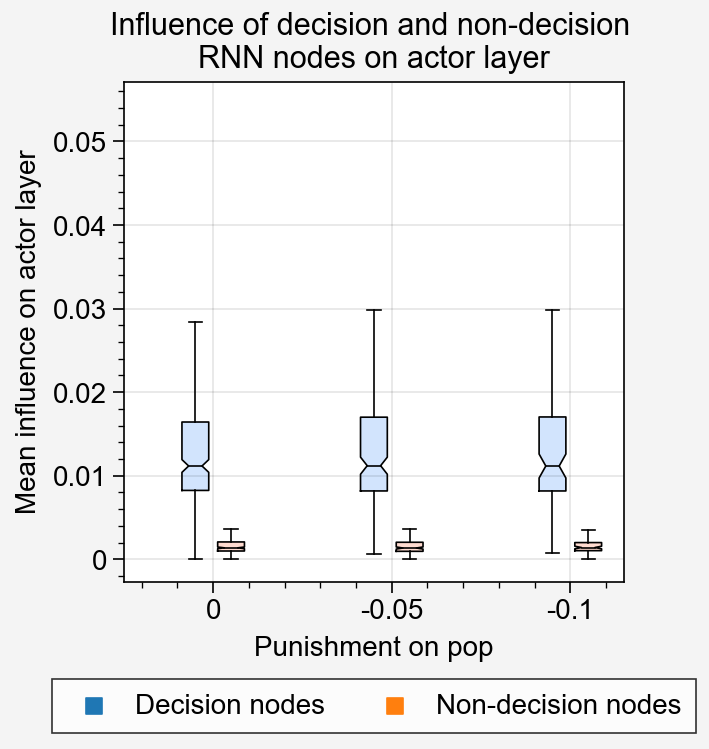

In [231]:
fig, ax = pplt.subplots()
for i in range(len(postfixes)):
    dec = dec_flow_scores[i:, :, :, :, 0].reshape(-1)
    nondec = dec_flow_scores[i:, :, :, :, 1].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, fc=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, fc=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(3)+0.1, xformatter=['0', '-0.05', '-0.1'],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 2.4])

## With give rew in obs

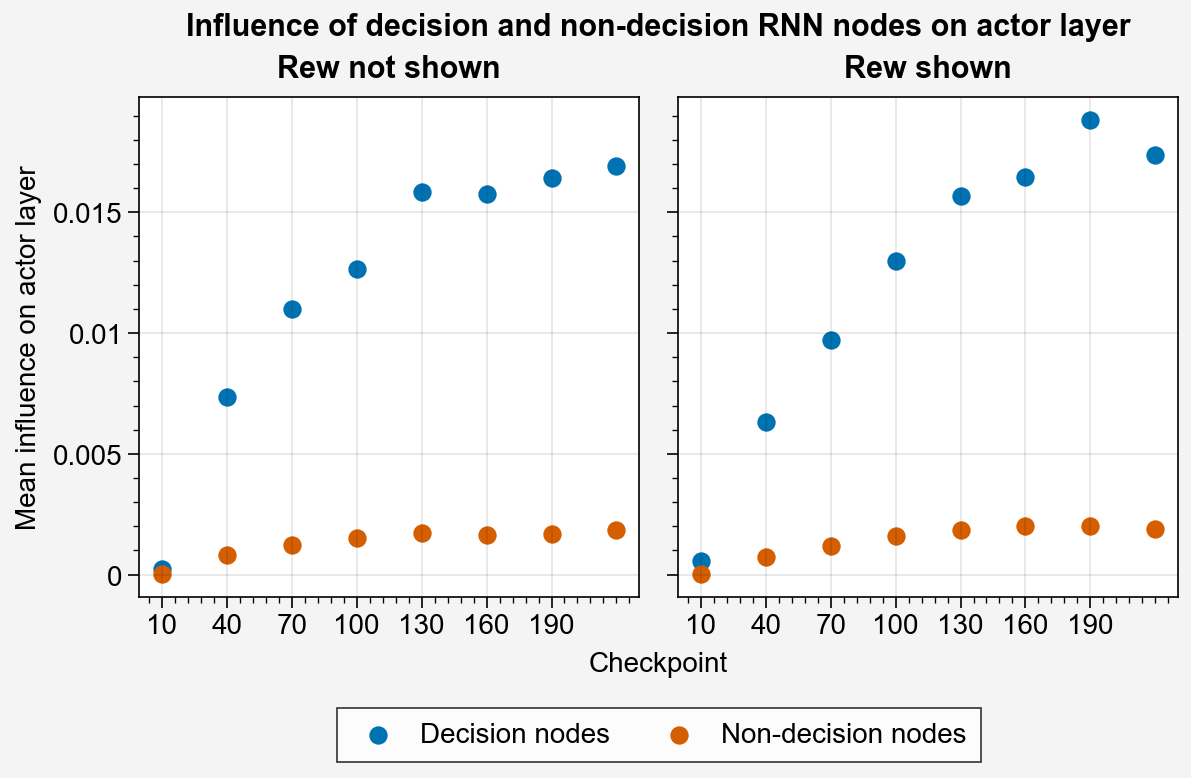

In [12]:
fig, ax = pplt.subplots(ncols=2)

dec_flow_scores = res['dec_flow_scores']
for i in range(2):
    lines = []
    lines.append(ax[i].scatter(dec_flow_scores.mean(axis=(0, 1, 2))[i, :, 0], 
                               label='Decision nodes'))
    lines.append(ax[i].scatter(dec_flow_scores.mean(axis=(0, 1, 2))[i, :, 1], 
                               label='Non-decision nodes'))
fig.legend(lines, loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(7), xformatter=[str(c) for c in chks],
            ylabel='Mean influence on actor layer',
            suptitle='Influence of decision and non-decision RNN nodes on actor layer',
            toplabels=give_labels)

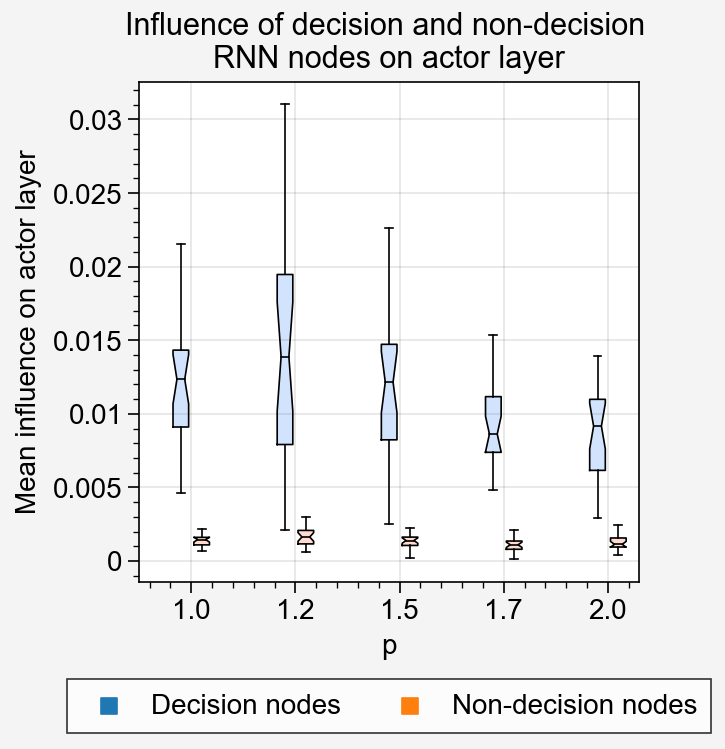

In [21]:
fig, ax = pplt.subplots()
for i in range(len(models)):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0], 'first')
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1], 'first')
    
    dec = dec[:, :, i, :].reshape(-1)
    nondec = nondec[:, :, i, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 4.4])

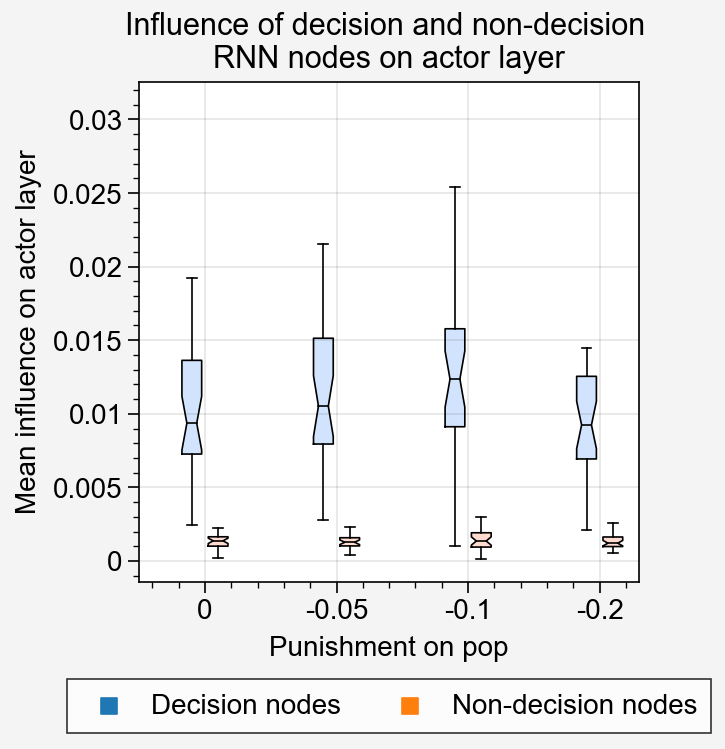

In [20]:
fig, ax = pplt.subplots()
for i in range(4):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0], 'first')
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1], 'first')
    
    dec = dec[:, i, :, :].reshape(-1)
    nondec = nondec[:, i, :, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel=pop_axis, xlocator=np.arange(4)+0.1, xformatter=pop_labels,
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 3.4])

p-value: 0.0742


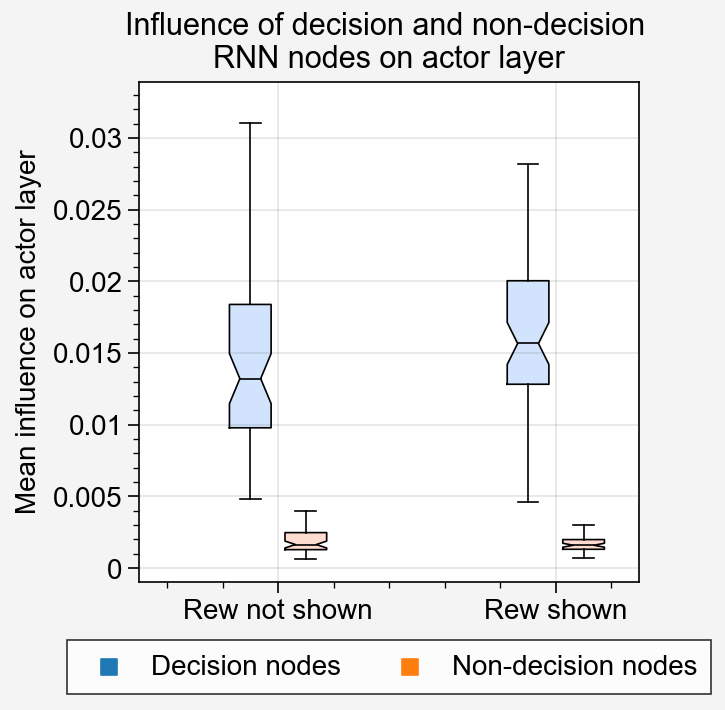

In [19]:
fig, ax = pplt.subplots()
ys = []
for h in range(2):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0])
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1])
    
    dec = dec[h, :, :, :].reshape(-1)
    nondec = nondec[h, :, :, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ys.append(dec)
    ax.boxplot(h, dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot(h+0.2, nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    

print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlocator=np.arange(2)+0.1, xformatter=give_labels,
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 1.4])

p-value: 0.7065


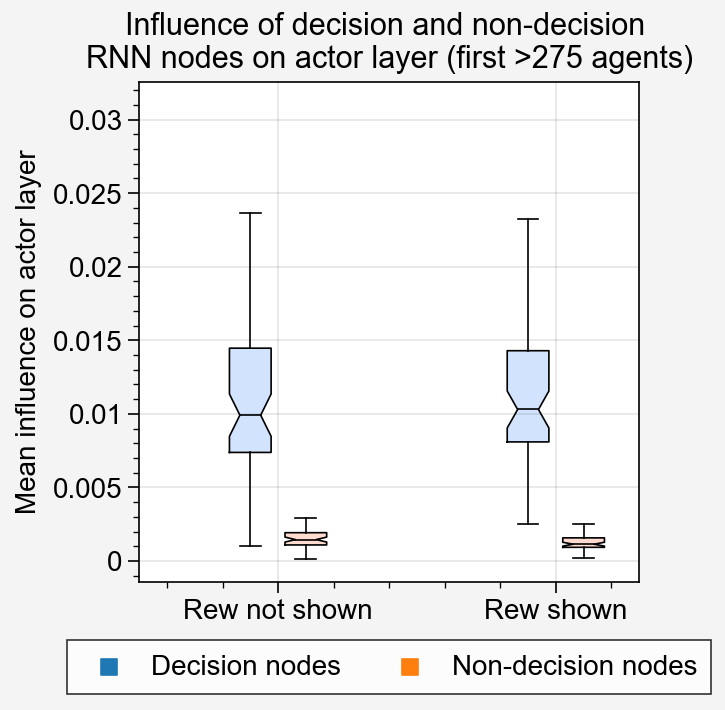

In [19]:
fig, ax = pplt.subplots()
ys = []
for h in range(2):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0], 'first')
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1], 'first')
    
    dec = dec[h, :, :, :].reshape(-1)
    nondec = nondec[h, :, :, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ys.append(dec)
    ax.boxplot(h, dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot(h+0.2, nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    

print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlocator=np.arange(2)+0.1, xformatter=give_labels,
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer (first >275 agents)',
            xlim=[-0.4, 1.4])

## Decision node counts

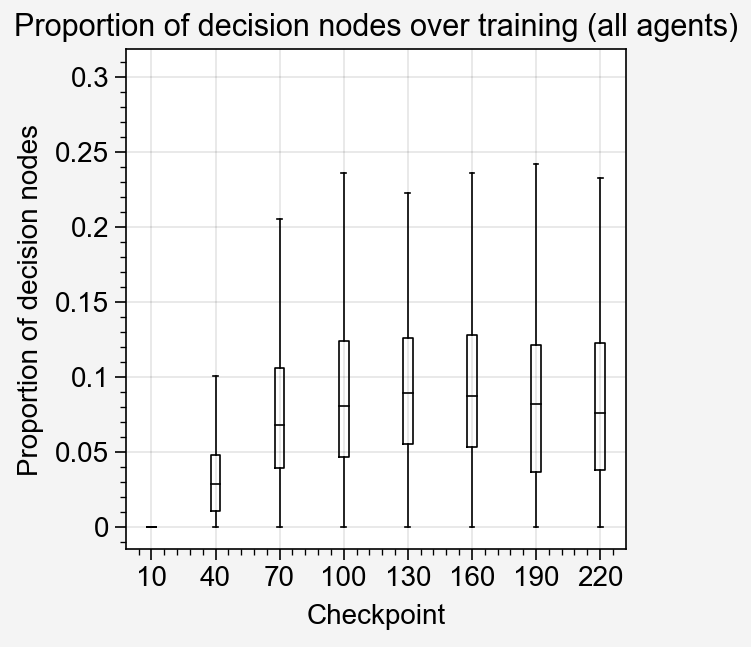

In [8]:
all_decision_nodes = res['all_decision_nodes']
fig, ax = pplt.subplots()
for i in range(len(chks)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=-1).mean(axis=-1)[:, :, :, :, i].reshape(-1) / 64, fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(17), xformatter=[str(c) for c in chks],
            ylabel='Proportion of decision nodes',
            title='Proportion of decision nodes over training (all agents)',
            xlim=[-0.4, 7.4])

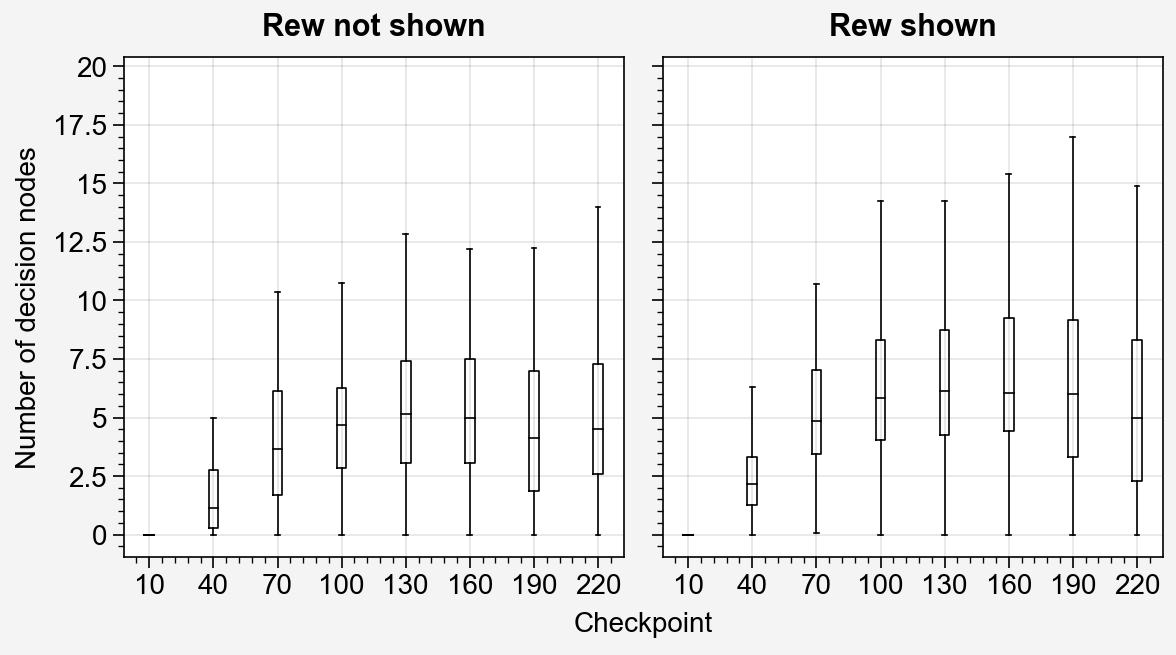

In [23]:
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    all_decision_nodes = res['all_decision_nodes'][h]
    for i in range(len(chks)):
        # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
        ax[h].boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[:, :, :, i].reshape(-1), fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(17), xformatter=[str(c) for c in chks],
            toplabels=give_labels,
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 7.4])

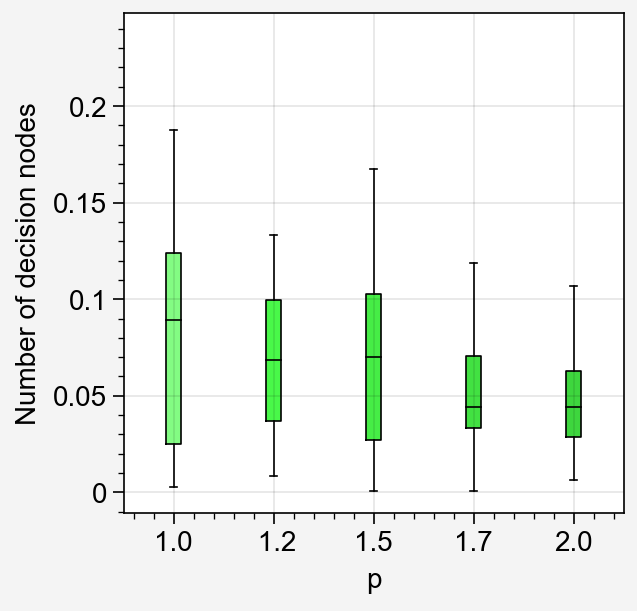

In [24]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')
for j in range(5):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(1, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(j, all_decision_nodes[:, :, j, :].reshape(-1), 
               fliers=False, cycle=rgb_colors[2])
# ax.legend(loc='b')
ax.format(xlabel=p_axis, xlocator=np.arange(5), xformatter=p_labels,
            ylabel='Number of decision nodes',
            title='')

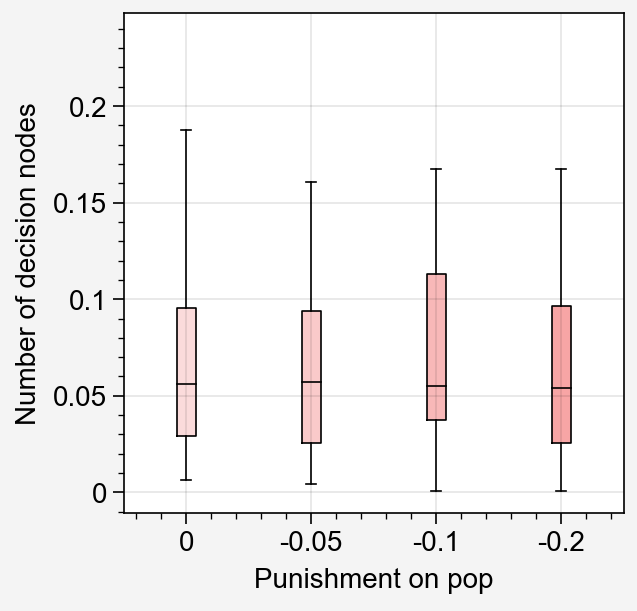

In [26]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')
for i in range(4):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(1, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes[:, i, :, :].reshape(-1), 
               fliers=False, cycle=rgb_colors[3])
# ax.legend(loc='b')
ax.format(xlabel=pop_axis, xlocator=np.arange(4), xformatter=pop_labels,
            ylabel='Number of decision nodes',
            title='')

p-value: 0.0624


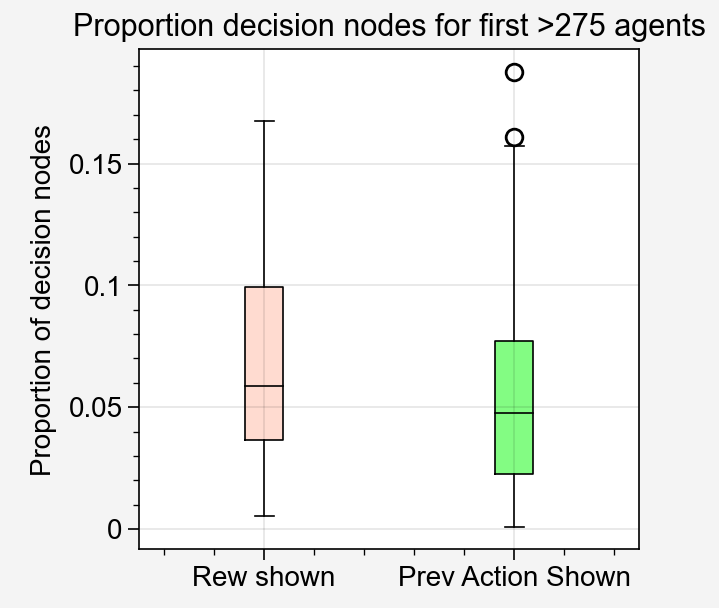

In [16]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')

ys = []
for h in range(1, 3):
    y = all_decision_nodes[h].reshape(-1)
    ys.append(y)
    ax.boxplot(h, y, cycle=rgb_colors[h])
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
# ax.legend(loc='b')
ax.format(xlocator=np.arange(1, 3), xformatter=give_labels[1:],
            ylabel='Proportion of decision nodes',
            title='Proportion decision nodes for first >275 agents',
            )

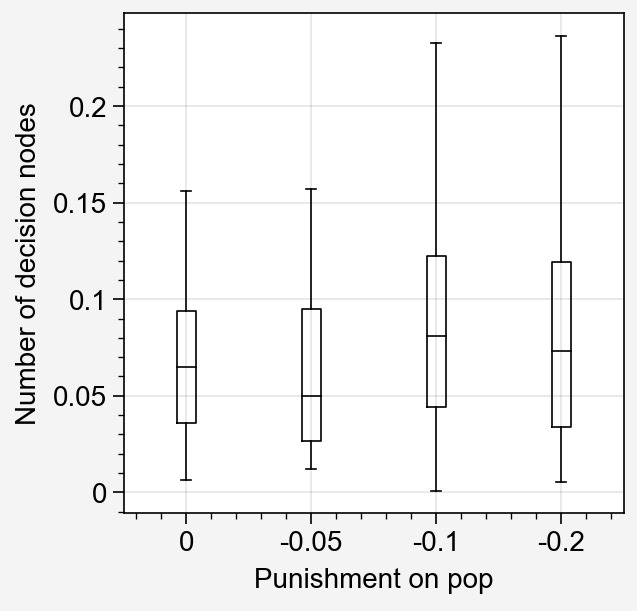

In [10]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')

for i in range(4):
    y = all_decision_nodes[:, i, :, :].reshape(-1)
    ax.boxplot(i, y)
    
ax.format(xlocator=np.arange(4), xformatter=pop_labels, xlabel=pop_axis,
            ylabel='Number of decision nodes',
            title='')

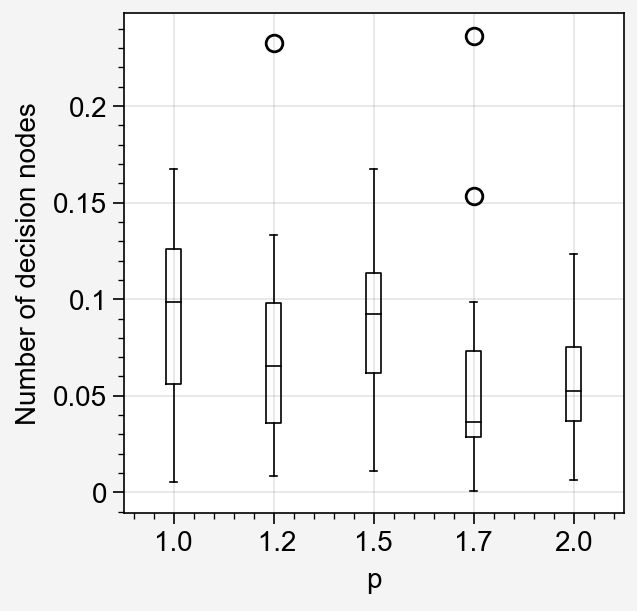

In [12]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')

ys = []
for j in range(5):
    y = all_decision_nodes[:, :, j, :].reshape(-1)
    ys.append(y)
    ax.boxplot(j, y)
    
ax.format(xlocator=np.arange(5), xformatter=p_labels, xlabel=p_axis,
            ylabel='Number of decision nodes',
            title='')

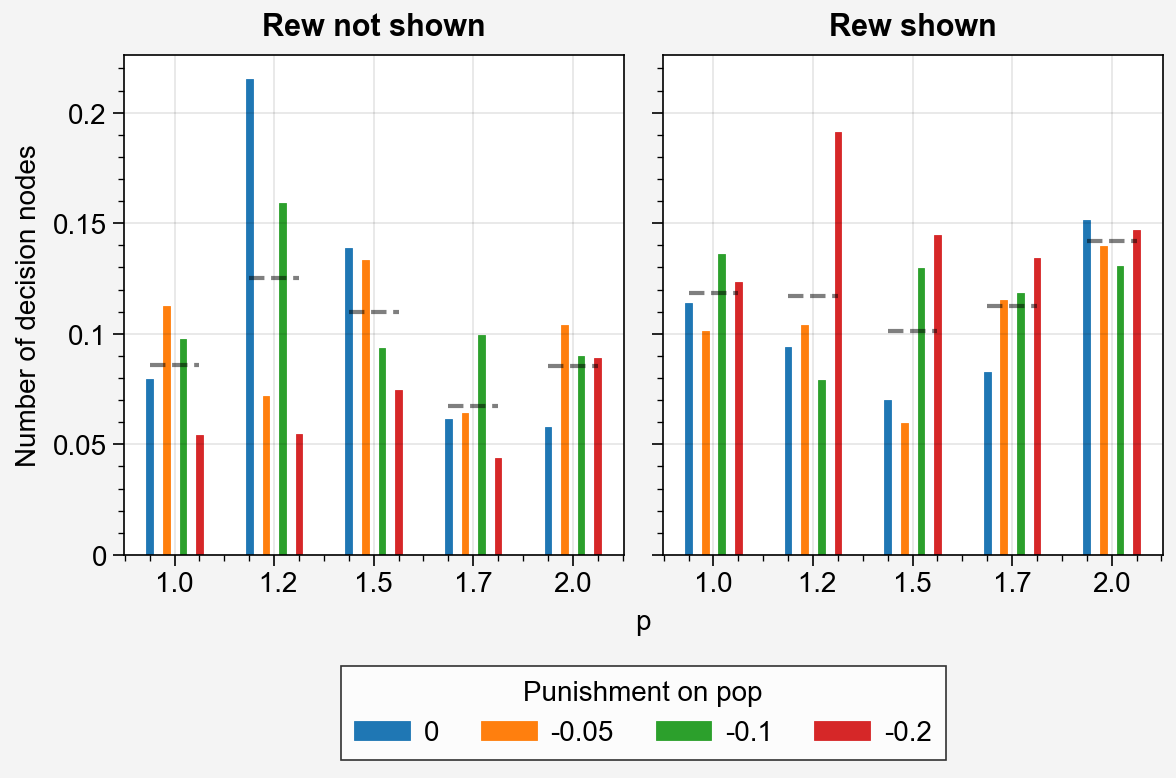

In [42]:
fig, ax = pplt.subplots(ncols=2)
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes)
    
for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = all_decision_nodes[h, i, j, :].mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)
        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(5)*6+1.5, xformatter=p_labels, xlabel=p_axis,
            ylabel='Number of decision nodes',
            toplabels=give_labels,
            title='')

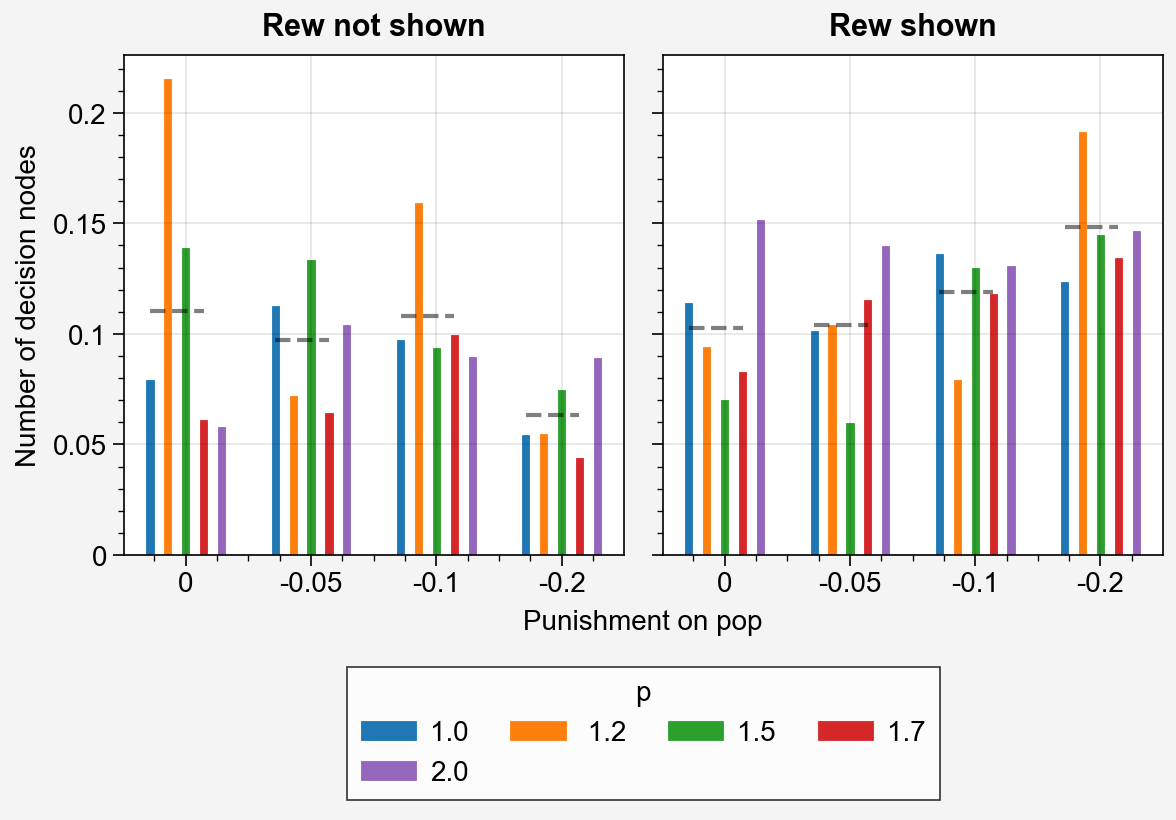

In [47]:
fig, ax = pplt.subplots(ncols=2)
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes)
    
for h in range(2):
    for i in range(len(pop_labels)):
        bars = []
        ys = []
        for j in range(len(p_labels)):
            x = i*7+j
            y = all_decision_nodes[h, i, j, :].mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[j], label=p_labels[j]))
            ys.append(y)
        y = np.mean(ys)
        ax[h].plot([i*7+0, i*7+3], [y, y], c='black', ls='--', alpha=0.5)
        
fig.legend(bars, loc='b', title=p_axis, ncols=4)
ax.format(xlocator=np.arange(5)*7+2, xformatter=pop_labels, xlabel=pop_axis,
            ylabel='Number of decision nodes',
            toplabels=give_labels,
            title='')

# Decision node consistency

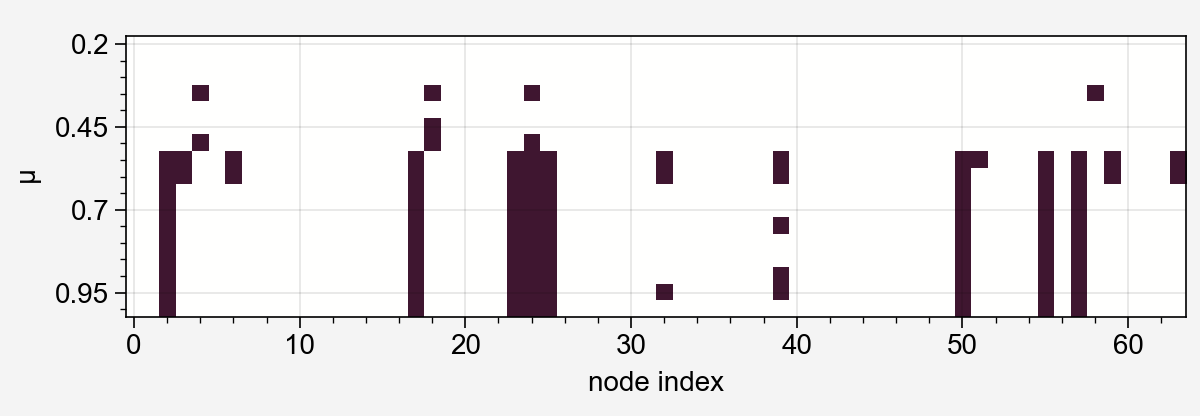

In [331]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/100.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)
all_dec_nodes = np.zeros((17, 64))
for ep in range(17):
    decision_nodes = find_decision_nodes(res, model, ep)
    all_dec_nodes[ep] = decision_nodes*1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)
ax.format(xlabel='node index', ylabel='$\mu$', ylocator=np.arange(0, 16, 5), yrotation=0,
          yformatter=[str(m) for m in np.arange(0, 16, 5)*0.05+0.2])

### Same episode consistency

In [71]:
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, 0.5, 0]} for i in range(20)]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=20,
                seed=1,
                deterministic=False,
                with_activations=True)

In [322]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/240.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)

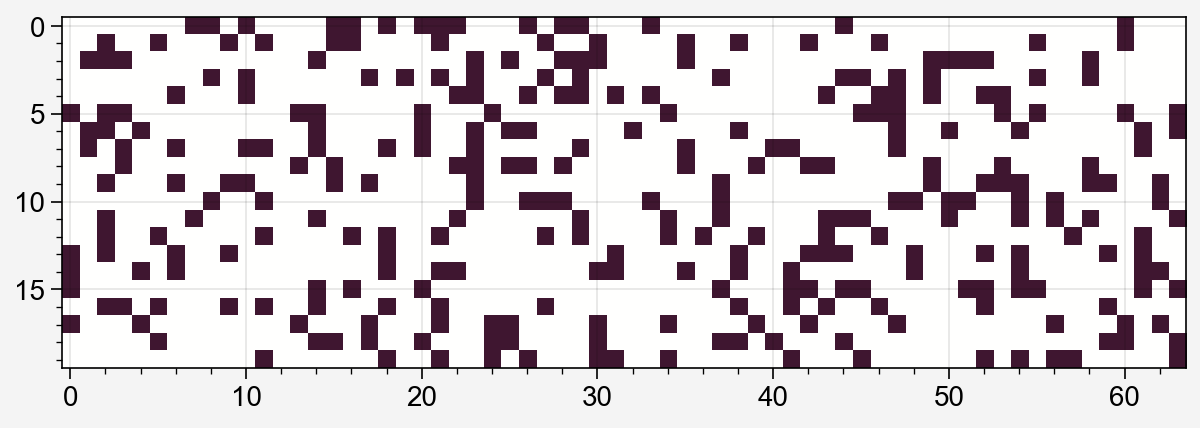

In [99]:
all_dec_nodes = np.zeros((20, 64))
for ep in range(20):
    idxs = np.random.choice(np.arange(64), size=15, replace=False)
    all_dec_nodes[ep, idxs] = 1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)

# Bimodal dynamics in RNN

In [6]:
from diptest import diptest
ares = pickle.load(open('data/meta_rnn_gradients', 'rb')) # dicts

In [26]:
idx = (1, 3, 3, 0)
rnn_hxs = ares['all_rnn_hxs'][idx]
lens = ares['all_ep_lens'][idx]
has_bimodal, ep_rnn, ps, n, ep_mean_rnn = find_bimodal_rnn_pca(rnn_hxs, lens)

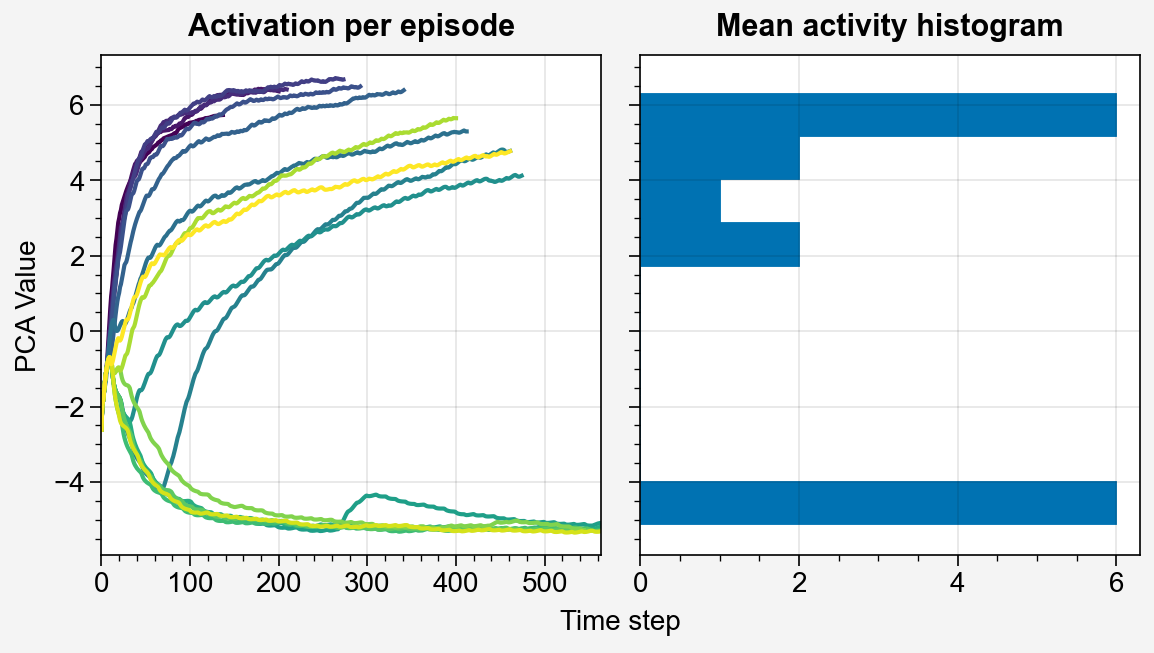

In [34]:
n = np.argmin(ps)
fig, ax = pplt.subplots(ncols=2)

bsizes = np.arange(0.2, 1.01, 0.05)
vmin = 0.2
vmax = 1

for j in range(17):
    s = bsizes[j]
    c = get_color_from_colormap(s, vmin, vmax, to_hex=False) 
    pca = ep_rnn[j][:, n]
    ax[0].plot(list(pd.Series(pca).ewm(alpha=0.01).mean()),
            c=c)

ax[1].hist(ep_mean_rnn[:, n], orientation='horizontal')
ax.format(ylabel='PCA Value', toplabels=['Activation per episode', 
                                         'Mean activity histogram'])
ax[0].format(xlabel='Time step')
ax[1].format(xlabel='Frequency')

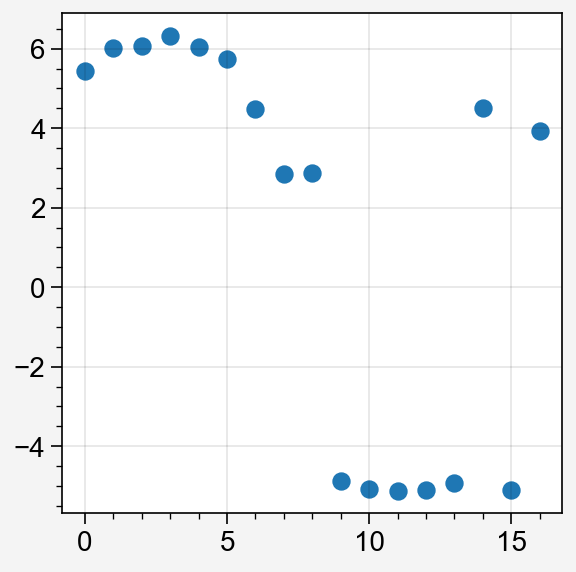

In [ ]:
n = np.argmin(ps)
fig, ax = pplt.subplots()
for j in range(17):
    ax.scatter(j, ep_rnn[j].mean(axis=0)[n], c=rgb_colors[0])

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


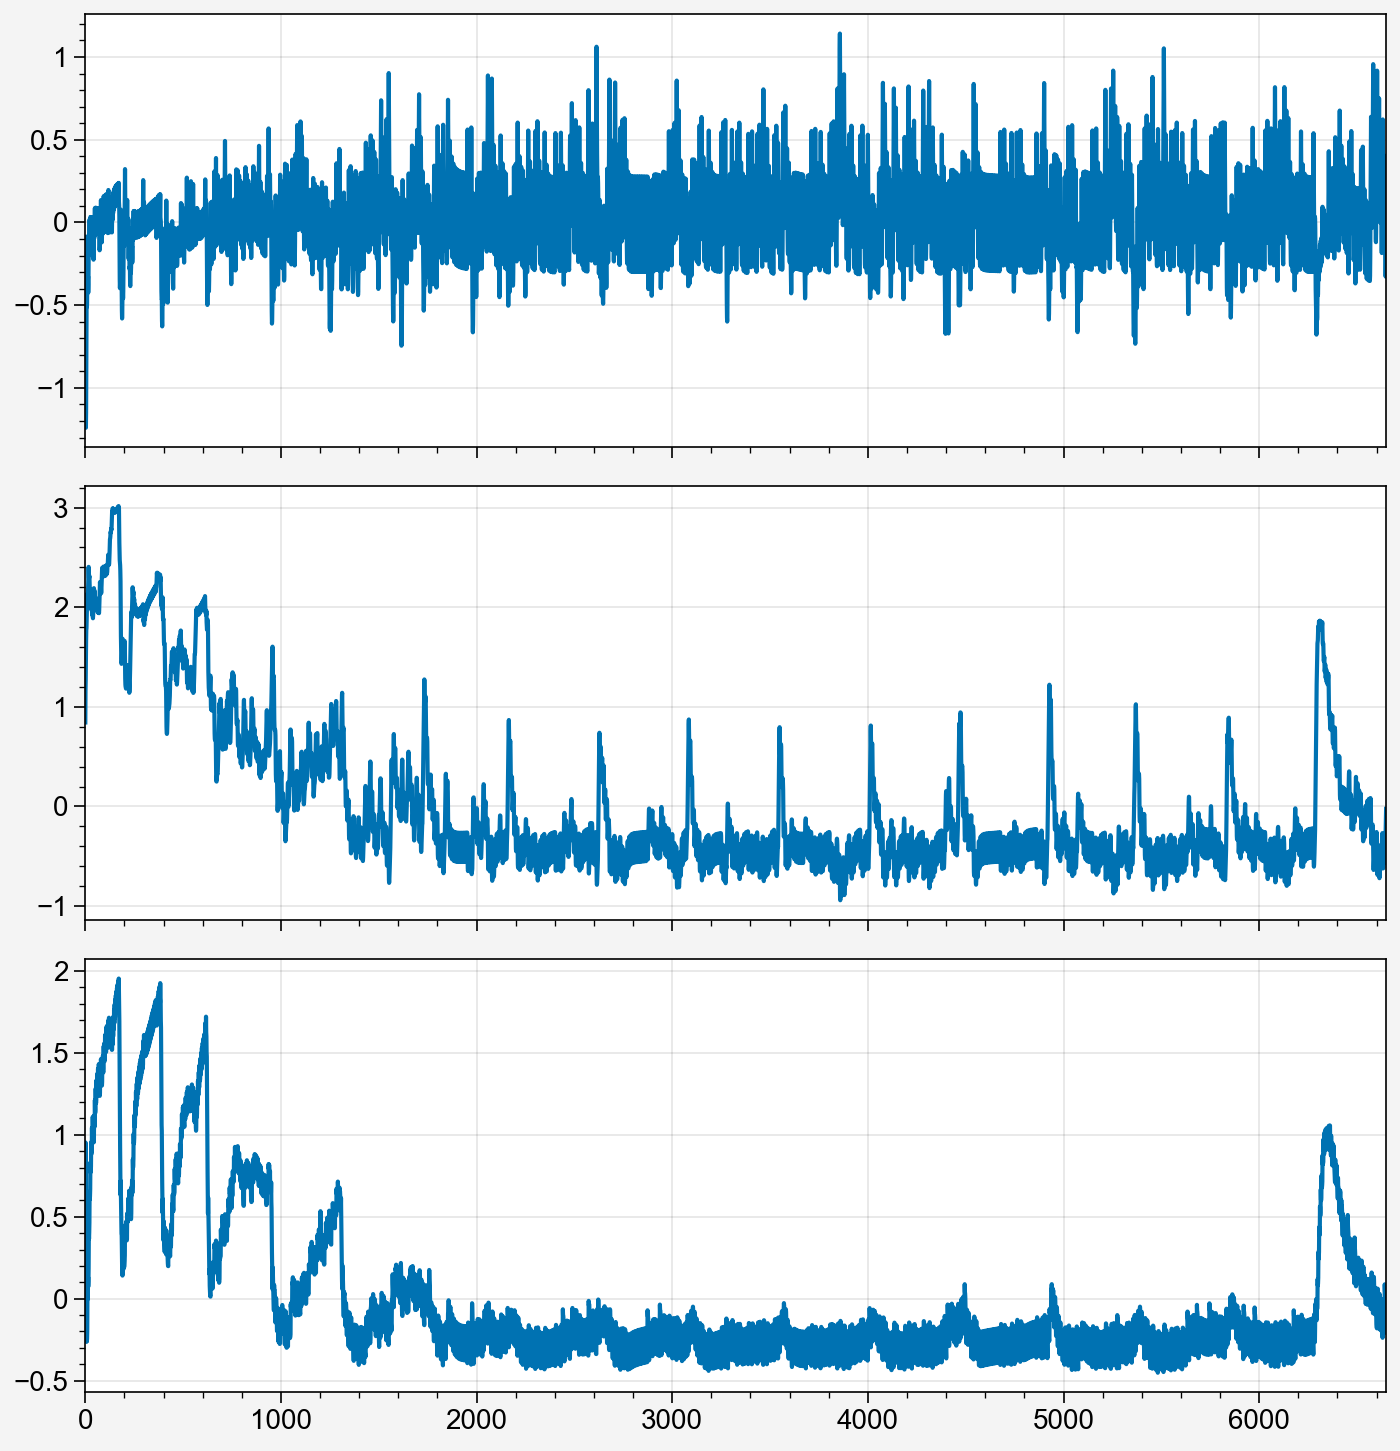

In [19]:
fig, ax = pplt.subplots(nrows=3, refaspect=3, figwidth=7)
for i in range(3):
    ax[i].plot(pd.Series(rnn_pc[:, i]).ewm(alpha=0.1).mean())

In [7]:
shape = (2, 4, 5, 10)
chkidxs = select_chks_by_dimension()
idxs = [i[:4] for i in chkidxs]
bimodal_rnn = np.zeros(shape)
bimodal_nodes = np.zeros(shape + (64,))
for idx in idxs:
    rnn_hxs = ares['all_rnn_hxs'][idx]
    data = rnn_hxs.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    rnn_hxs = data_normalized.squeeze().T  # Back to shape [T, 64]
    pca = PCA(n_components=5)
    rnn_pc = pca.fit_transform(rnn_hxs)
    lens = ares['all_ep_lens'][idx]
    ep_rnn = split_by_lens(lens, rnn_pc)

    ep_mean_rnn = [r.mean(axis=0) for r in ep_rnn]
    ep_mean_rnn = np.vstack(ep_mean_rnn)
    ps = []
    for i in range(ep_mean_rnn.shape[1]):
        _, p = diptest(ep_mean_rnn[:, i])
        ps.append(p)
    i = np.argmin(ps)
    comp = np.abs(pca.components_[i])
    perc = np.percentile(comp, 80)
    bimodal_nodes[idx] = (comp > perc) * 1
    bimodal_rnn[idx] = (min(ps) < 0.05) * 1

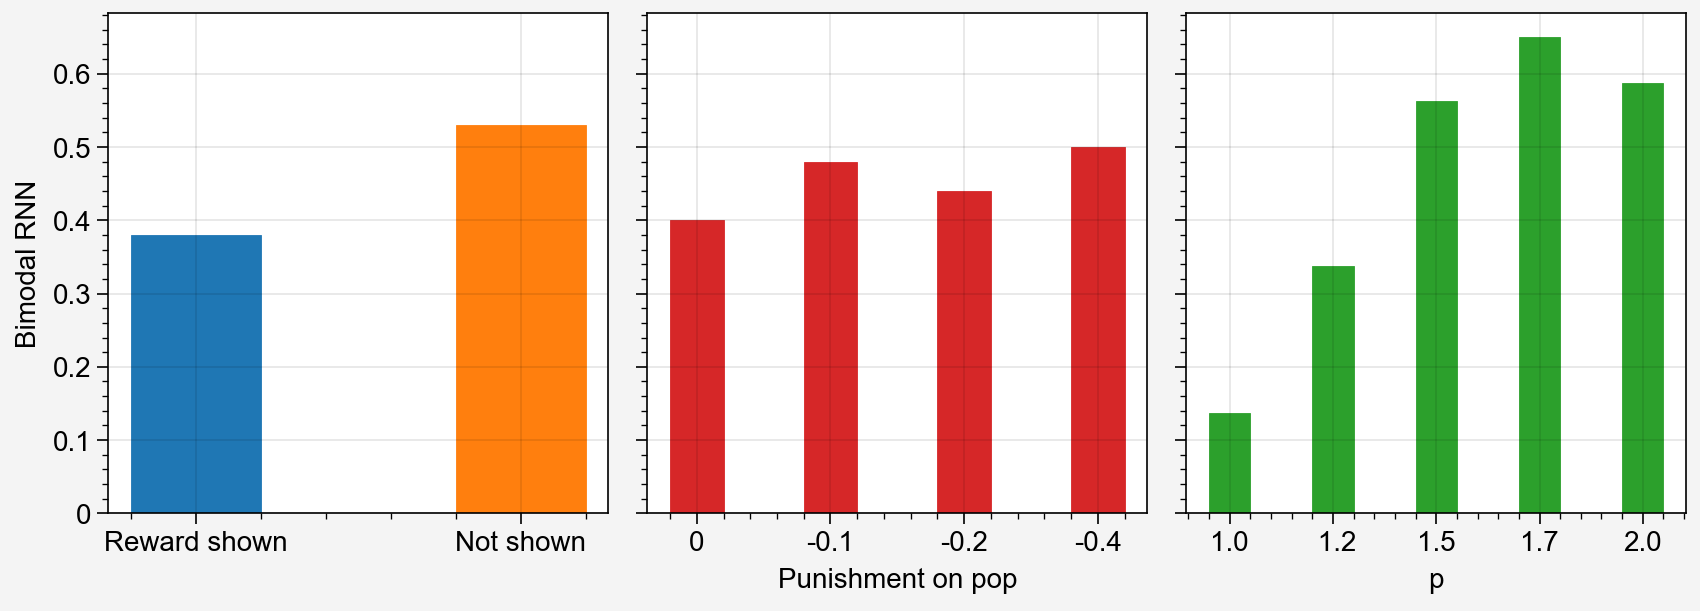

In [8]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h)
    bimodal = []
    for idx in idxs:
        bimodal.append(bimodal_rnn[idx])
    ax[0].bar(h, np.mean(bimodal), c=rgb_colors[h])
for i in range(4):
    idxs = select_chks_by_dimension(i=i)
    bimodal = []
    for idx in idxs:
        bimodal.append(bimodal_rnn[idx])
    ax[1].bar(i, np.mean(bimodal), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j)
    bimodal = []
    for idx in idxs:
        bimodal.append(bimodal_rnn[idx])
    ax[2].bar(j, np.mean(bimodal), c=rgb_colors[2])

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Bimodal RNN')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)
    